In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
#sys.path.insert(1, '/nfs/team283/ed6/cellLocModel/')
path = '/nfs/team283/aa16/'
#import cellLocModel as clm
import pycell2location.models as c2l
import pycell2location.plt as c2lpl
import pycell2location.cluster_averages 
from matplotlib import rcParams
import seaborn as sns
# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [101]:
# Load data and metadata:

counts = pd.read_table(path + 'KR_NAS/Sanger_288ROIs_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')
subset_genes = np.array([sum(counts.iloc[i,:]) for i in range(len(counts.iloc[:,0]))]) > 3 * 288
counts = counts[subset_genes]
metadata = pd.read_csv(path + 'KR_NAS/NanoString sequencing all annotations 2020.02.10.csv')
metadata = metadata.iloc[0:286,]
metadata = metadata.rename(index=metadata['Sanger_sampleID'])
metadata = metadata.reindex(np.array(counts.columns))
properties = pd.read_table(path + 'KR_NAS/Sanger_288ROIs_SegmentProperties.txt')
properties = properties.rename(index=properties['DSP_Sample_ID'])
properties = properties.reindex(np.array(metadata['Sample_ID']))
columnNames = ('x', 'y', 'total_counts', 'Q3_counts')
sample_info = pd.DataFrame(index=metadata['Sample_ID'], columns=columnNames)
sample_info['x'] = np.array(metadata['VCDepth'])
sample_info['y'] = np.array(metadata['Radial_position'])
sample_info['total_counts'] = [sum(counts.iloc[:,i]) for i in range(len(counts.iloc[1,:]))] 
sample_info['Q3_counts'] = [sum(np.sort(counts.iloc[:,i])[int(np.round(0.5*len(counts.iloc[:,i]))):int(np.round(0.75*len(counts.iloc[:,i])))]) for i in range(len(counts.iloc[1,:]))]
negProbes = pd.read_csv(path + 'KR_NAS/Sanger_dedup_withNegProbes.csv')
negProbes = negProbes.loc[negProbes.iloc[:,0] == 'NegProbe-WTX',]
genes = negProbes['Unnamed: 0']
negProbes = negProbes.drop('Unnamed: 0',1)
negProbes = negProbes.rename(index=genes)
negProbes = negProbes.astype('int')
negProbes = negProbes[counts.keys()]
polioudakis = pd.read_csv('/nfs/team283/brainData/human_fetal/Polioudakis2019/cellStateMatrix.csv')
genes = polioudakis.iloc[:,0]
polioudakis = polioudakis.drop('Unnamed: 0',1)
polioudakis = polioudakis.rename(index=genes)

# Choose which ROIs and genes to use, e.g. top 100 markers of each cell type:
rSlides = ('00MU', '00MV', '00MV-2')

markers = pd.read_csv('/nfs/team283/brainData/human_fetal/Polioudakis2019/clusterMarkers.csv')

# Choose the top N markers only:

N = 75
columnNames = np.unique(markers['cluster'])
topN_markers = pd.DataFrame(index=range(N), columns=columnNames)
for i in range(len(columnNames)):
    topN_temp = np.array(markers[markers['cluster'] == columnNames[i]].iloc[0:N,].iloc[:,0])
    topN_markers[columnNames[i]] = [topN_temp[i].split('.')[0] for i in range(len(topN_temp))]
genes_new = np.array(topN_markers).flatten()  

subset = np.where([metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,2,3)
                   and metadata['AOI_type'][i] in ('Geometric', 'EOMESpos', 'HOPXpos', 'Ring', 'Residual')
                            for i in range(len(metadata['slide']))])[0]


Y_data = np.array(negProbes.iloc[:,subset]).T
counts_subset = counts.iloc[:,subset]
subset_genes = [counts_subset.index[i] in genes_new for i in range(len(counts_subset.index))]
counts_subset = counts_subset.iloc[subset_genes,:]
cellstateMatrix = polioudakis.reindex(np.array(counts_subset.index))
n_nuclei = np.array(properties['nuclei'])[subset]

In [352]:
# -*- coding: utf-8 -*-
"""V7 Cell location model with better motivated hierarchical priors."""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os

from pycell2location.models.pymc3_loc_model import Pymc3LocModel 

# defining the model itself
class LocationModelV7_V4_V4_GeoMx_V1(Pymc3LocModel):
    r"""V7 Cell location model with better motivated hierarchical priors. 
    This model assumes the cell types present in each spot share an equal amount of total spot budget 
    (in terms of total N cells). 
    Relaxing that assumption would mean learning how large individual cell types 
    are in terms of their size / contribution to spots / extraction efficiencies.
    :param cell_state_mat: Pandas data frame with gene signatures - genes in row, cell states or factors in columns
    :param X_data: Numpy array of gene expression (cols) in spatial locations (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    :param gene_level_prior: prior on change in sensitivity between single cell and spatial (mean), 
                                how much it varies across cells (sd),
                                and how certain we are in those numbers (mean_var_ratio) 
                                 - by default the variance in our prior of mean and sd is equal to the mean and sd
                                 descreasing this number means having higher uncertainty about your prior
    :param cell_number_prior: prior on cell density parameter:
                                cells_per_spot - guess of the number of cells per location
                                factors_per_spot - guess on the number of cell types 
                                                        / number of factors expressed per locations
                                cells_mean_var_ratio, factors_mean_var_ratio - uncertainty in that guess
                                                        measured as mean/var ratio, numbers < 1 mean high uncertainty
    """

    def __init__(
        self,
        cell_state_mat: np.ndarray,
        X_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 15000,
        learning_rate = 0.005,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        gene_level_prior={'mean': 1/8, 'sd': 1/8, 'mean_var_ratio': 1},
        cell_number_prior={'cells_per_spot': 7, 'factors_per_spot': 6,
                           'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1}
    ):

        ############# Initialise parameters ################
        super().__init__(cell_state_mat, X_data,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose, var_names, var_names_read,
                         obs_names, fact_names, sample_id)
        
        self.gene_level_prior = gene_level_prior
        self.cell_number_prior = cell_number_prior        
        
        ############# Define the model ################
        self.model = pm.Model()

        with self.model:
            
            # =====================Gene expression level scaling======================= #
            # Explains difference in expression between genes and 
            # how it differs in single cell and spatial technology
            # compute hyperparameters from mean and sd
            shape = gene_level_prior['mean']**2 / gene_level_prior['sd']**2
            rate = gene_level_prior['mean'] / gene_level_prior['sd']**2 
            shape_var = shape / gene_level_prior['mean_var_ratio']
            rate_var = rate / gene_level_prior['mean_var_ratio']
            self.gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp',
                                                 mu=shape, sigma=np.sqrt(shape_var),
                                                 shape=(1, 1))
            self.gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 
                                                 mu=rate, sigma=np.sqrt(rate_var),
                                                 shape=(1, 1))
        
            self.gene_level = pm.Gamma('gene_level', self.gene_level_alpha_hyp,
                                       self.gene_level_beta_hyp, shape=(self.n_genes, 1))
        
            # scale cell state factors by gene_level
            self.gene_factors = pm.Deterministic('gene_factors', self.cell_state)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0).shape)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0))
    
            # =====================Spot factors======================= #
            # prior on spot factors reflects the number of cells, fraction of their cytoplasm captured, 
            # times heterogeniety in the total number of mRNA between individual cells with each cell type
            self.cells_per_spot = pm.Gamma('cells_per_spot',
                                           mu=self.cell_number_prior['cells_per_spot'],
                                           sigma=np.sqrt(self.cell_number_prior['cells_per_spot'] \
                                                         / self.cell_number_prior['cells_mean_var_ratio']),
                                           shape=(self.n_cells, 1))
            self.factors_per_spot = pm.Gamma('factors_per_spot', 
                                             mu=self.cell_number_prior['factors_per_spot'], 
                                             sigma=np.sqrt(self.cell_number_prior['factors_per_spot'] \
                                                           / self.cell_number_prior['factors_mean_var_ratio']),
                                             shape=(self.n_cells, 1))
            
            shape = self.factors_per_spot / np.array(self.n_fact).reshape((1, 1))
            rate = tt.ones((1, 1)) / self.cells_per_spot * self.factors_per_spot
            self.spot_factors = pm.Gamma('spot_factors', alpha=shape, beta=rate,
                                         shape=(self.n_cells, self.n_fact))
    
            # =====================Spot-specific additive component======================= #
            # molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed between all genes not just expressed genes
            self.spot_add_hyp = pm.Gamma('spot_add_hyp', 1, 0.1, shape=2)
            self.spot_add = pm.Gamma('spot_add', self.spot_add_hyp[0],
                                     self.spot_add_hyp[1], shape=(self.n_cells, 1))
            
            # =====================Gene-specific additive component ======================= #
            # per gene molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed equally between all spots (e.g. background, free-floating RNA)
            self.gene_add_hyp = pm.Gamma('gene_add_hyp', 1, 1, shape=2)
            self.gene_add = pm.Gamma('gene_add', self.gene_add_hyp[0],
                                     self.gene_add_hyp[1], shape=(self.n_genes, 1))
    
            # =====================Expected expression ======================= #
            # expected expression
            self.mu_biol = pm.math.dot(self.spot_factors, self.gene_factors.T) * self.gene_level.T + self.gene_add.T + self.spot_add
            #tt.printing.Print('mu_biol')(self.mu_biol.shape)
    
            # =====================DATA likelihood ======================= #
            # Likelihood (sampling distribution) of observations & add overdispersion via NegativeBinomial / Poisson
            self.data_target = pm.Poisson('data_target', mu=self.mu_biol,
                                          observed=self.x_data,
                                          total_size=self.X_data.shape)
                                          
            # =====================Compute nUMI from each factor in spots  ======================= #                          
            self.nUMI_factors = pm.Deterministic('nUMI_factors',
                                                 (self.spot_factors * (self.gene_factors * self.gene_level).sum(0)))
    
    def plot_posterior_vs_dataV1(self):
        self.plot_posterior_vs_data(gene_fact_name = 'gene_factors',
                               cell_fact_name = 'spot_factors_scaled')
    
    def plot_biol_spot_nUMI(self, fact_name='nUMI_factors'):
        
        plt.hist(np.log10(self.samples['post_sample_means'][fact_name].sum(1)), bins = 50)
        plt.xlabel('Biological spot nUMI (log10)')
        plt.title('Biological spot nUMI')
        plt.tight_layout()
        
    def plot_spot_add(self):
        
        plt.hist(np.log10(self.samples['post_sample_means']['spot_add'][:,0]), bins = 50)
        plt.xlabel('UMI unexplained by biological factors')
        plt.title('Additive technical spot nUMI')
        plt.tight_layout()
        
        
    def plot_gene_add(self):
        
        plt.hist((self.samples['post_sample_means']['gene_add'][:,0]), bins = 50)
        plt.xlabel('S_g additive background noise parameter')
        plt.title('S_g additive background noise parameter')
        plt.tight_layout()
        
    def plot_gene_level(self):
        
        plt.hist((self.samples['post_sample_means']['gene_level'][:,0]), bins = 50)
        plt.xlabel('M_g expression level scaling parameter')
        plt.title('M_g expression level scaling parameter')
        plt.tight_layout()
        
    def compute_expected(self):
        r""" Compute expected expression of each gene in each spot (Poisson mu). Useful for evaluating how well the model learned expression pattern of all genes in the data.
        """
        
        # compute the poisson rate
        self.mu = np.dot(self.samples['post_sample_means']['spot_factors'],
                         self.samples['post_sample_means']['gene_factors'].T) \
        * self.samples['post_sample_means']['gene_level'].T \
        + self.samples['post_sample_means']['gene_add'].T \
        + self.samples['post_sample_means']['spot_add']


In [353]:
# -*- coding: utf-8 -*-
"""V7 Cell location model with better motivated hierarchical priors."""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os

from pycell2location.models.pymc3_loc_model import Pymc3LocModel 

# defining the model itself
class LocationModelV7_V4_V4_GeoMx_V2(Pymc3LocModel):
    r"""V7 Cell location model with better motivated hierarchical priors. Additionally, uses Gamma and not Poisson
    for counts over 10000. 
    This model assumes the cell types present in each spot share an equal amount of total spot budget 
    (in terms of total N cells). 
    Relaxing that assumption would mean learning how large individual cell types 
    are in terms of their size / contribution to spots / extraction efficiencies.
    :param cell_state_mat: Pandas data frame with gene signatures - genes in row, cell states or factors in columns
    :param X_data: Numpy array of gene expression (cols) in spatial locations (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    :param gene_level_prior: prior on change in sensitivity between single cell and spatial (mean), 
                                how much it varies across cells (sd),
                                and how certain we are in those numbers (mean_var_ratio) 
                                 - by default the variance in our prior of mean and sd is equal to the mean and sd
                                 descreasing this number means having higher uncertainty about your prior
    :param cell_number_prior: prior on cell density parameter:
                                cells_per_spot - guess of the number of cells per location
                                factors_per_spot - guess on the number of cell types 
                                                        / number of factors expressed per locations
                                cells_mean_var_ratio, factors_mean_var_ratio - uncertainty in that guess
                                                        measured as mean/var ratio, numbers < 1 mean high uncertainty
    """

    def __init__(
        self,
        cell_state_mat: np.ndarray,
        X_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 15000,
        learning_rate = 0.005,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        gene_level_prior={'mean': 1/8, 'sd': 1/8, 'mean_var_ratio': 1},
        cell_number_prior={'cells_per_spot': 7, 'factors_per_spot': 6,
                           'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1},
        cutoff_poisson = 10000
    ):

        ############# Initialise parameters ################
        super().__init__(cell_state_mat, X_data,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose, var_names, var_names_read,
                         obs_names, fact_names, sample_id)
        
        self.gene_level_prior = gene_level_prior
        self.cell_number_prior = cell_number_prior
        self.cutoff_poisson = cutoff_poisson
        self.poisson_residual = self.X_data < self.cutoff_poisson
        self.gamma_residual = self.X_data > self.cutoff_poisson
        self.X_data1 = self.X_data[self.poisson_residual]
        self.X_data2 = self.X_data[self.gamma_residual]
        
        ############# Define the model ################
        self.model = pm.Model()

        with self.model:
            
            # =====================Gene expression level scaling======================= #
            # Explains difference in expression between genes and 
            # how it differs in single cell and spatial technology
            # compute hyperparameters from mean and sd
            shape = gene_level_prior['mean']**2 / gene_level_prior['sd']**2
            rate = gene_level_prior['mean'] / gene_level_prior['sd']**2 
            shape_var = shape / gene_level_prior['mean_var_ratio']
            rate_var = rate / gene_level_prior['mean_var_ratio']
            self.gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp',
                                                 mu=shape, sigma=np.sqrt(shape_var),
                                                 shape=(1, 1))
            self.gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 
                                                 mu=rate, sigma=np.sqrt(rate_var),
                                                 shape=(1, 1))
        
            self.gene_level = pm.Gamma('gene_level', self.gene_level_alpha_hyp,
                                       self.gene_level_beta_hyp, shape=(self.n_genes, 1))
        
            # scale cell state factors by gene_level
            self.gene_factors = pm.Deterministic('gene_factors', self.cell_state)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0).shape)
            #tt.printing.Print('gene_factors sum')(gene_factors.sum(0))
    
            # =====================Spot factors======================= #
            # prior on spot factors reflects the number of cells, fraction of their cytoplasm captured, 
            # times heterogeniety in the total number of mRNA between individual cells with each cell type
            self.cells_per_spot = pm.Gamma('cells_per_spot',
                                           mu=self.cell_number_prior['cells_per_spot'],
                                           sigma=np.sqrt(self.cell_number_prior['cells_per_spot'] \
                                                         / self.cell_number_prior['cells_mean_var_ratio']),
                                           shape=(self.n_cells, 1))
            self.factors_per_spot = pm.Gamma('factors_per_spot', 
                                             mu=self.cell_number_prior['factors_per_spot'], 
                                             sigma=np.sqrt(self.cell_number_prior['factors_per_spot'] \
                                                           / self.cell_number_prior['factors_mean_var_ratio']),
                                             shape=(self.n_cells, 1))
            
            shape = self.factors_per_spot / np.array(self.n_fact).reshape((1, 1))
            rate = tt.ones((1, 1)) / self.cells_per_spot * self.factors_per_spot
            self.spot_factors = pm.Gamma('spot_factors', alpha=shape, beta=rate,
                                         shape=(self.n_cells, self.n_fact))
    
            # =====================Spot-specific additive component======================= #
            # molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed between all genes not just expressed genes
            self.spot_add_hyp = pm.Gamma('spot_add_hyp', 1, 0.1, shape=2)
            self.spot_add = pm.Gamma('spot_add', self.spot_add_hyp[0],
                                     self.spot_add_hyp[1], shape=(self.n_cells, 1))
            
            # =====================Gene-specific additive component ======================= #
            # per gene molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed equally between all spots (e.g. background, free-floating RNA)
            self.gene_add_hyp = pm.Gamma('gene_add_hyp', 1, 1, shape=2)
            self.gene_add = pm.Gamma('gene_add', self.gene_add_hyp[0],
                                     self.gene_add_hyp[1], shape=(self.n_genes, 1))
    
            # =====================Expected expression ======================= #
            # expected expression
            self.mu_biol = pm.math.dot(self.spot_factors, self.gene_factors.T) * self.gene_level.T + self.gene_add.T + self.spot_add          
            
            # =====================DATA likelihood ======================= #
            # Likelihood (sampling distribution) of observations & add overdispersion via NegativeBinomial / Poisson
            self.data_target1 = pm.Poisson('data_target1', mu=self.mu_biol[self.poisson_residual],
                                          observed=self.x_data[self.poisson_residual],
                                          total_size=self.X_data[self.poisson_residual].shape)
            
            self.data_target2 = pm.Gamma('data_target2', mu=self.mu_biol[self.gamma_residual],
                                          sd = np.sqrt(self.mu_biol[self.gamma_residual]),
                                          observed=self.x_data[self.gamma_residual],
                                          total_size=self.X_data[self.gamma_residual].shape)
                                          
            # =====================Compute nUMI from each factor in spots  ======================= #                          
            self.nUMI_factors = pm.Deterministic('nUMI_factors',
                                                 (self.spot_factors * (self.gene_factors * self.gene_level).sum(0)))
    
    def plot_posterior_vs_dataV1(self):
        self.plot_posterior_vs_data(gene_fact_name = 'gene_factors',
                               cell_fact_name = 'spot_factors_scaled')
    
    def plot_biol_spot_nUMI(self, fact_name='nUMI_factors'):
        
        plt.hist(np.log10(self.samples['post_sample_means'][fact_name].sum(1)), bins = 50)
        plt.xlabel('Biological spot nUMI (log10)')
        plt.title('Biological spot nUMI')
        plt.tight_layout()
        
    def plot_spot_add(self):
        
        plt.hist(np.log10(self.samples['post_sample_means']['spot_add'][:,0]), bins = 50)
        plt.xlabel('UMI unexplained by biological factors')
        plt.title('Additive technical spot nUMI')
        plt.tight_layout()
        
        
    def plot_gene_add(self):
        
        plt.hist((self.samples['post_sample_means']['gene_add'][:,0]), bins = 50)
        plt.xlabel('S_g additive background noise parameter')
        plt.title('S_g additive background noise parameter')
        plt.tight_layout()
        
    def plot_gene_level(self):
        
        plt.hist((self.samples['post_sample_means']['gene_level'][:,0]), bins = 50)
        plt.xlabel('M_g expression level scaling parameter')
        plt.title('M_g expression level scaling parameter')
        plt.tight_layout()
        
    def compute_expected(self):
        r""" Compute expected expression of each gene in each spot (Poisson mu). Useful for evaluating how well the model learned expression pattern of all genes in the data.
        """
        
        # compute the poisson rate/gamma mean:
        self.mu = np.dot(self.samples['post_sample_means']['spot_factors'],
                         self.samples['post_sample_means']['gene_factors'].T) \
        * self.samples['post_sample_means']['gene_level'].T \
        + self.samples['post_sample_means']['gene_add'].T \
        + self.samples['post_sample_means']['spot_add']
        
        self.mu1 = self.mu[self.poisson_residual]
        self.mu2 = self.mu[self.gamma_residual] 
        
    def plot_prior_vs_data(self, data_target_name=('data_target1', 'data_target2'),
                           data_node=('X_data1', 'X_data2')):
        r""" Plot data vs a single sample from the prior in a 2D histogram
        Uses self.X_data and self.prior_trace['data_target'].
        :param data_node: name of the object slot containing data
        """
        
        if len(data_node) == 1:
            data_node = getattr(self, data_node)
            plt.hist2d(np.log10(data_node.flatten()+1),
            np.log10(self.prior_trace[data_target_name].flatten()+1),
            bins = 50, norm=matplotlib.colors.LogNorm())
            plt.xlabel('Data, log10(nUMI)')
            plt.ylabel('Prior sample, log10(nUMI)')
            plt.title('UMI counts (all spots, all genes)')
            plt.tight_layout()
        else:
            data_node_list = []
            for i in range(len(data_node)):
                data_node_list.append(getattr(self, data_node[i]))
            fig, ax = plt.subplots(1, 2, figsize = (20,10))
            for i in range(len(data_node_list)):
                ax[i].hist2d(np.log10(data_node_list[i].flatten()+1),
                np.log10(self.prior_trace[data_target_name[i]].flatten()+1),
                bins = 50, norm=matplotlib.colors.LogNorm())
                ax[i].set_xlabel('Data, log10(nUMI)', fontsize=25)
                ax[i].set_ylabel('Prior sample, log10(nUMI)', fontsize=25)
                ax[i].set_title(data_target_name[i] + ': UMI counts (all spots, all genes)', fontsize=25)
                ax[i].tick_params(axis='both', which='major', labelsize=25)
                ax[i].tick_params(axis='both', which='minor', labelsize=25)

            plt.tight_layout()
        


In [410]:
# -*- coding: utf-8 -*-
"""V7 Cell location model with better motivated hierarchical priors."""

import sys, ast, os
import time
import itertools
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
import pickle
import theano

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
from tqdm.auto import tqdm

from pycell2location.models.pymc3_loc_model import Pymc3LocModel 

# defining the model itself
class LocationModelV7_V4_V4_GeoMx_V3(Pymc3LocModel):
    r"""V7 Cell location model with better motivated hierarchical priors. Additionally, uses Gamma and not Poisson
    for counts over 10000. Additionally, uses a more accurate model for the background counts, based on negative probe counts,
    in which background increases linearly with the total number of counts in each spot.
    This model assumes the cell types present in each spot share an equal amount of total spot budget 
    (in terms of total N cells). 
    Relaxing that assumption would mean learning how large individual cell types 
    are in terms of their size / contribution to spots / extraction efficiencies.
    :param cell_state_mat: Pandas data frame with gene signatures - genes in row, cell states or factors in columns
    :param X_data: Numpy array of gene expression (cols) in spatial locations (rows)
    :param learning_rate: ADAM learning rate for optimising Variational inference objective
    :param n_iter: number of training iterations
    :param total_grad_norm_constraint: gradient constraints in optimisation
    :param gene_level_prior: prior on change in sensitivity between single cell and spatial (mean), 
                                how much it varies across cells (sd),
                                and how certain we are in those numbers (mean_var_ratio) 
                                 - by default the variance in our prior of mean and sd is equal to the mean and sd
                                 descreasing this number means having higher uncertainty about your prior
    :param cell_number_prior: prior on cell density parameter:
                                cells_per_spot - guess of the number of cells per location
                                factors_per_spot - guess on the number of cell types 
                                                        / number of factors expressed per locations
                                cells_mean_var_ratio, factors_mean_var_ratio - uncertainty in that guess
                                                        measured as mean/var ratio, numbers < 1 mean high uncertainty
    """

    def __init__(
        self,
        cell_state_mat: np.ndarray,
        X_data: np.ndarray,
        Y_data: np.ndarray,
        data_type: str = 'float32',
        n_iter = 15000,
        learning_rate = 0.005,
        total_grad_norm_constraint = 200,
        verbose = True,
        var_names=None, var_names_read=None,
        obs_names=None, fact_names=None, sample_id=None,
        gene_level_prior={'mean': 1/8, 'sd': 1/8, 'mean_var_ratio': 1},
        cell_number_prior={'cells_per_spot': 7, 'factors_per_spot': 6,
                           'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1},
        cutoff_poisson = 10000,
        cv_y_rn = 0.01
    ):

        ############# Initialise parameters ################
        super().__init__(cell_state_mat, X_data,
                         data_type, n_iter, 
                         learning_rate, total_grad_norm_constraint,
                         verbose, var_names, var_names_read,
                         obs_names, fact_names, sample_id)
        
        self.gene_level_prior = gene_level_prior
        self.cell_number_prior = cell_number_prior
        self.cutoff_poisson = cutoff_poisson
        self.poisson_residual = self.X_data < self.cutoff_poisson
        self.gamma_residual = self.X_data > self.cutoff_poisson
        self.X_data1 = self.X_data[self.poisson_residual]
        self.X_data2 = self.X_data[self.gamma_residual]
        
        self.Y_data = Y_data
        self.y_data = theano.shared(Y_data.astype(self.data_type))
        self.n_rois = Y_data.shape[0]
        self.x_r = np.array([np.sum(X_data[i,:]) for i in range(self.n_rois)]).reshape(self.n_rois,1)/10**(5)
        self.cv_y_r = cv_y_rn
        self.n_npro = Y_data.shape[1]
        
        ############# Define the model ################
        self.model = pm.Model()

        with self.model:
            # =====================Negative Probe Counts======================= #
            # Explain negative probe counts as linearly dependent on total counts and with
            # scaling coefficient a_n drawn from a gamma distribution.
            
            # Prior for distribution of negative probe count levels:
            self.a_n_hyper = pm.Gamma('a_n_hyper', mu = np.array((2,1)), sd = np.array((0.1,0.1)), shape = 2)
            # The distribution of negative probe count levels:
            self.a_n = pm.Gamma('a_n', alpha = self.a_n_hyper[0], beta = self.a_n_hyper[1], shape = (1,self.n_npro))
            # The expected mean of each negative probe based on its count level and total counts in this roi:
            self.mu_n = self.a_n*self.x_r
            # How much deviation from this expected mean is allowed depends on the self.cv_y_r parameter:
            self.y_rn = pm.Gamma('y_rn', mu = self.mu_n, sigma = self.cv_y_r*self.mu_n, shape = (self.n_rois,self.n_npro))
            
            # =====================Gene expression level scaling======================= #
            # Explains difference in expression between genes and 
            # how it differs in single cell and spatial technology
            # compute hyperparameters from mean and sd
            shape = gene_level_prior['mean']**2 / gene_level_prior['sd']**2
            rate = gene_level_prior['mean'] / gene_level_prior['sd']**2 
            shape_var = shape / gene_level_prior['mean_var_ratio']
            rate_var = rate / gene_level_prior['mean_var_ratio']
            self.gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp',
                                                 mu=shape, sigma=np.sqrt(shape_var),
                                                 shape=(1, 1))
            self.gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 
                                                 mu=rate, sigma=np.sqrt(rate_var),
                                                 shape=(1, 1))
        
            self.gene_level = pm.Gamma('gene_level', self.gene_level_alpha_hyp,
                                       self.gene_level_beta_hyp, shape=(self.n_genes, 1))
        
            # scale cell state factors by gene_level
            self.gene_factors = pm.Deterministic('gene_factors', self.cell_state)
    
            # =====================Spot factors======================= #
            # prior on spot factors reflects the number of cells, fraction of their cytoplasm captured, 
            # times heterogeniety in the total number of mRNA between individual cells with each cell type
            self.cells_per_spot = pm.Gamma('cells_per_spot',
                                           mu=self.cell_number_prior['cells_per_spot'],
                                           sigma=np.sqrt(self.cell_number_prior['cells_per_spot'] \
                                                         / self.cell_number_prior['cells_mean_var_ratio']),
                                           shape=(self.n_cells, 1))
            self.factors_per_spot = pm.Gamma('factors_per_spot', 
                                             mu=self.cell_number_prior['factors_per_spot'], 
                                             sigma=np.sqrt(self.cell_number_prior['factors_per_spot'] \
                                                           / self.cell_number_prior['factors_mean_var_ratio']),
                                             shape=(self.n_cells, 1))
            
            shape = self.factors_per_spot / np.array(self.n_fact).reshape((1, 1))
            rate = tt.ones((1, 1)) / self.cells_per_spot * self.factors_per_spot
            self.spot_factors = pm.Gamma('spot_factors', alpha=shape, beta=rate,
                                         shape=(self.n_cells, self.n_fact))
    
            # =====================Spot-specific additive component======================= #
            # molecule contribution that cannot be explained by cell state signatures
            # these counts are distributed between all genes not just expressed genes
            self.spot_add_hyp = pm.Gamma('spot_add_hyp', 1, 0.1, shape=2)
            self.spot_add = pm.Gamma('spot_add', self.spot_add_hyp[0],
                                     self.spot_add_hyp[1], shape=(self.n_cells, 1))
            
            # =====================Gene-specific additive component ======================= #
            # This term models background and non-specific binding of probes.
            # We assume it has is has the same distribution as negative probes:
            self.a_g = pm.Gamma('a_g', alpha = self.a_n_hyper[0], beta = self.a_n_hyper[1], shape = (1, self.n_genes))
            self.mu_gr = (self.a_g*self.x_r).T
            self.gene_add = pm.Gamma('gene_add', mu = self.mu_gr, sigma = self.cv_y_r*self.mu_gr, shape = (self.n_genes, self.n_cells))
    
            # =====================Expected expression ======================= #
            # expected expression
            self.mu_biol = pm.math.dot(self.spot_factors, self.gene_factors.T) * self.gene_level.T + self.gene_add.T + self.spot_add
            #tt.printing.Print('mu_biol')(self.mu_biol.shape)            
            
            # =====================DATA likelihood ======================= #
            
            # Poisson sampling of negative probes:
            self.data_target0 = pm.Poisson('data_target0', mu=self.y_rn,
                                          observed=self.y_data,
                                          total_size=self.Y_data.shape)
            
            # Poisson sampling of gene counts up to 10000:
            self.data_target1 = pm.Poisson('data_target1', mu=self.mu_biol[self.poisson_residual],
                                          observed=self.x_data[self.poisson_residual],
                                          total_size=self.X_data[self.poisson_residual].shape)
            
            # Approximate Poisson by Gamma for gene counts over 10000:
            self.data_target2 = pm.Gamma('data_target2', mu=self.mu_biol[self.gamma_residual],
                                          sd = np.sqrt(self.mu_biol[self.gamma_residual]),
                                          observed=self.x_data[self.gamma_residual],
                                          total_size=self.X_data[self.gamma_residual].shape)
                                          
            # =====================Compute nUMI from each factor in spots  ======================= #                          
            self.nUMI_factors = pm.Deterministic('nUMI_factors',
                                                 (self.spot_factors * (self.gene_factors * self.gene_level).sum(0)))
    
    def plot_posterior_vs_dataV1(self):
        self.plot_posterior_vs_data(gene_fact_name = 'gene_factors',
                               cell_fact_name = 'spot_factors_scaled')
    
    def plot_biol_spot_nUMI(self, fact_name='nUMI_factors'):
        
        plt.hist(np.log10(self.samples['post_sample_means'][fact_name].sum(1)), bins = 50)
        plt.xlabel('Biological spot nUMI (log10)')
        plt.title('Biological spot nUMI')
        plt.tight_layout()
        
    def plot_spot_add(self):
        
        plt.hist(np.log10(self.samples['post_sample_means']['spot_add'][:,0]), bins = 50)
        plt.xlabel('UMI unexplained by biological factors')
        plt.title('Additive technical spot nUMI')
        plt.tight_layout()
        
        
    def plot_gene_add(self):
        
        plt.hist((self.samples['post_sample_means']['gene_add'][:,0]), bins = 50)
        plt.xlabel('S_g additive background noise parameter')
        plt.title('S_g additive background noise parameter')
        plt.tight_layout()
        
    def plot_gene_level(self):
        
        plt.hist((self.samples['post_sample_means']['gene_level'][:,0]), bins = 50)
        plt.xlabel('M_g expression level scaling parameter')
        plt.title('M_g expression level scaling parameter')
        plt.tight_layout()
        
    def compute_expected(self):
        r""" Compute expected expression of each gene in each spot (Poisson mu). Useful for evaluating how well the model learned expression pattern of all genes in the data.
        """
        
        # compute the poisson rate/gamma mean:
        self.mu = np.dot(self.samples['post_sample_means']['spot_factors'],
                         self.samples['post_sample_means']['gene_factors'].T) \
        * self.samples['post_sample_means']['gene_level'].T \
        + self.samples['post_sample_means']['gene_add'].T \
        + self.samples['post_sample_means']['spot_add']
        
        self.mun = self.samples['post_sample_means']['a_n']*self.x_r
        self.mu1 = self.mu[self.poisson_residual]
        self.mu2 = self.mu[self.gamma_residual]
        
    def plot_prior_vs_data(self, data_target_name=('data_target0', 'data_target1', 'data_target2'),
                           data_node=('Y_data', 'X_data1', 'X_data2')):
        r""" Plot data vs a single sample from the prior in a 2D histogram
        Uses self.X_data and self.prior_trace['data_target'].
        :param data_node: name of the object slot containing data
        """
        
        if len(data_node) == 1:
            data_node = getattr(self, data_node)
            plt.hist2d(np.log10(data_node.flatten()+1),
            np.log10(self.prior_trace[data_target_name].flatten()+1),
            bins = 50, norm=matplotlib.colors.LogNorm())
            plt.xlabel('Data, log10(nUMI)')
            plt.ylabel('Prior sample, log10(nUMI)')
            plt.title('UMI counts (all spots, all genes)')
            plt.tight_layout()
        else:
            data_node_list = []
            for i in range(len(data_node)):
                data_node_list.append(getattr(self, data_node[i]))
            fig, ax = plt.subplots(1, 3, figsize = (30,10))
            for i in range(len(data_node_list)):
                ax[i].hist2d(np.log10(data_node_list[i].flatten()+1),
                np.log10(self.prior_trace[data_target_name[i]].flatten()+1),
                bins = 50, norm=matplotlib.colors.LogNorm())
                ax[i].set_xlabel('Data, log10(nUMI)', fontsize=25)
                ax[i].set_ylabel('Prior sample, log10(nUMI)', fontsize=25)
                ax[i].set_title(data_target_name[i] + ': UMI counts (all spots, all genes)', fontsize=25)
                ax[i].tick_params(axis='both', which='major', labelsize=25)
                ax[i].tick_params(axis='both', which='minor', labelsize=25)

            plt.tight_layout()
            
    def sample_a_n_prior(self, n_samples = 100):
        r""" Sample the a_n parameter prior.
        :return: self.a_n_prior with 100 sampled values for a_n 
        """
        # Take multiple prior samples for certain parameters
        self.a_n_prior = []
        for i in tqdm(range(n_samples)):
            with self.model:
                prior_trace = pm.sample_prior_predictive(samples=1, var_names = ['a_n'])
            self.a_n_prior.append(prior_trace['a_n'][0][0])
        
    def plot_a_n_prior_vs_data(self, n_samples = 100):
        r""" Sample the 
        :return: self.a_n_prior with 100 sampled values for a_n 
        """
        plt.hist(mod3.a_n_prior, bins = 50)
        
        

In [412]:
# mod1 = LocationModelV7_V4_V4_GeoMx_V1(
#         np.array(cellstateMatrix), np.array(counts_subset).T,
#         data_type='float32', n_iter=2000,
#         learning_rate=0.001,
#         total_grad_norm_constraint=200,
#         verbose=False, 
#         gene_level_prior={'mean': 1, 'sd': 1/2, 'mean_var_ratio': 1},
#         cell_number_prior={'cells_per_spot': n_nuclei.reshape(112,1), 'factors_per_spot': 5,
#                            'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1})

# mod2 = LocationModelV7_V4_V4_GeoMx_V2(
#         np.array(cellstateMatrix), np.array(counts_subset).T,
#         data_type='float32', n_iter=2000,
#         learning_rate=0.001,
#         total_grad_norm_constraint=200,
#         verbose=False, 
#         gene_level_prior={'mean': 1, 'sd': 1/2, 'mean_var_ratio': 1},
#         cell_number_prior={'cells_per_spot': n_nuclei.reshape(112,1), 'factors_per_spot': 5,
#                            'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1})

mod3 = LocationModelV7_V4_V4_GeoMx_V3(
        np.array(cellstateMatrix), np.array(counts_subset).T, Y_data,
        data_type='float32', n_iter=30000,
        learning_rate=0.001,
        total_grad_norm_constraint=200,
        verbose=False, 
        gene_level_prior={'mean': 1, 'sd': 1/2, 'mean_var_ratio': 1},
        cell_number_prior={'cells_per_spot': n_nuclei.reshape(112,1), 'factors_per_spot': 5,
                           'cells_mean_var_ratio': 1, 'factors_mean_var_ratio': 1})

In [401]:
# mod1.sample_prior()
# mod1.plot_prior_vs_data()
# plt.show()
# mod2.sample_prior()
# mod2.plot_prior_vs_data()
# plt.show()
# mod3.sample_prior()
# mod3.plot_prior_vs_data()
# plt.show()

In [413]:
#mod1.fit_advi(n=1, method='advi')
#mod2.fit_advi(n=1, method='advi')
mod3.fit_advi(n=1, method='advi')



Average Loss = 5.098e+08:   2%|▏         | 466/30000 [00:13<14:45, 33.35it/s] 


Average Loss = 4.6449e+08:   2%|▏         | 704/30000 [00:20<14:08, 34.54it/s]


Average Loss = 3.6253e+08:   4%|▍         | 1174/30000 [00:34<14:46, 32.50it/s]


Average Loss = 2.6293e+08:   5%|▌         | 1637/30000 [00:47<13:38, 34.66it/s]


Average Loss = 1.9486e+08:   7%|▋         | 2104/30000 [01:00<12:13, 38.01it/s]


Average Loss = 1.4187e+08:   9%|▊         | 2568/30000 [01:14<14:06, 32.41it/s]


Average Loss = 1.0361e+08:  10%|█         | 3029/30000 [01:27<14:02, 32.01it/s]


Average Loss = 7.5632e+07:  12%|█▏        | 3493/30000 [01:41<13:21, 33.07it/s]


Average Loss = 5.4954e+07:  13%|█▎        | 3958/30000 [01:54<12:08, 35.75it/s]


Average Loss = 4.0402e+07:  15%|█▍        | 4419/30000 [02:08<12:25, 34.31it/s]


Average Loss = 2.9879e+07:  16%|█▋        | 4884/30000 [02:21<12:27, 33.61it/s]


Average Loss = 2.2316e+07:  18%|█▊        | 5349/30000 [02:35<12:58, 31.68it/s]


Average Loss = 1.6777e+07:  19%|█▉        | 5811/30000 [02:48<11:25, 35.30it/s]


Average Loss = 1.2863e+07:  21%|██        | 6279/30000 [03:02<12:27, 31.75it/s]


Average Loss = 9.9223e+06:  22%|██▏       | 6745/30000 [03:16<11:47, 32.87it/s]


Average Loss = 7.8835e+06:  24%|██▍       | 7213/30000 [03:29<11:25, 33.22it/s]


Average Loss = 6.3678e+06:  26%|██▌       | 7681/30000 [03:42<10:10, 36.56it/s]


Average Loss = 5.2878e+06:  27%|██▋       | 8148/30000 [03:56<10:31, 34.62it/s]


Average Loss = 4.4913e+06:  29%|██▊       | 8609/30000 [04:10<11:18, 31.54it/s]


Average Loss = 3.8855e+06:  30%|███       | 9068/30000 [04:23<10:20, 33.72it/s]


Average Loss = 3.4447e+06:  32%|███▏      | 9531/30000 [04:36<09:44, 35.02it/s]


Average Loss = 3.112e+06:  33%|███▎      | 9993/30000 [04:50<10:02, 33.19it/s]


Average Loss = 2.8546e+06:  35%|███▍      | 10453/30000 [05:04<09:02, 36.05it/s]


Average Loss = 2.6511e+06:  36%|███▋      | 10912/30000 [05:17<09:02, 35.16it/s]


Average Loss = 2.4843e+06:  38%|███▊      | 11370/30000 [05:30<08:33, 36.25it/s]


Average Loss = 2.342e+06:  39%|███▉      | 11830/30000 [05:44<08:33, 35.40it/s]


Average Loss = 2.2156e+06:  41%|████      | 12289/30000 [05:57<08:56, 33.03it/s]


Average Loss = 2.0985e+06:  42%|████▏     | 12746/30000 [06:11<08:54, 32.30it/s]


Average Loss = 1.9885e+06:  44%|████▍     | 13208/30000 [06:24<07:58, 35.08it/s]


Average Loss = 1.8783e+06:  46%|████▌     | 13670/30000 [06:37<08:35, 31.70it/s]


Average Loss = 1.7686e+06:  47%|████▋     | 14121/30000 [06:51<08:28, 31.20it/s]


Average Loss = 1.6594e+06:  49%|████▊     | 14578/30000 [07:04<07:19, 35.08it/s]


Average Loss = 1.554e+06:  50%|█████     | 15040/30000 [07:18<07:20, 33.96it/s]


Average Loss = 1.4473e+06:  52%|█████▏    | 15497/30000 [07:31<06:59, 34.54it/s]


Average Loss = 1.3501e+06:  53%|█████▎    | 15956/30000 [07:44<07:13, 32.43it/s]


Average Loss = 1.258e+06:  55%|█████▍    | 16414/30000 [07:58<06:38, 34.13it/s]


Average Loss = 1.175e+06:  56%|█████▌    | 16871/30000 [08:11<06:12, 35.29it/s]


Average Loss = 1.1024e+06:  58%|█████▊    | 17327/30000 [08:24<06:36, 31.94it/s]


Average Loss = 1.0405e+06:  59%|█████▉    | 17789/30000 [08:38<05:38, 36.11it/s]


Average Loss = 9.8982e+05:  61%|██████    | 18250/30000 [08:51<05:26, 35.96it/s]


Average Loss = 9.4664e+05:  62%|██████▏   | 18706/30000 [09:04<05:48, 32.38it/s]


Average Loss = 9.1282e+05:  64%|██████▍   | 19170/30000 [09:18<05:04, 35.54it/s]


Average Loss = 8.8665e+05:  65%|██████▌   | 19629/30000 [09:31<05:23, 32.10it/s]


Average Loss = 8.6579e+05:  67%|██████▋   | 20088/30000 [09:44<04:55, 33.50it/s]


Average Loss = 8.4979e+05:  68%|██████▊   | 20542/30000 [09:58<04:34, 34.46it/s]


Average Loss = 8.3762e+05:  70%|██████▉   | 20998/30000 [10:11<04:30, 33.34it/s]


Average Loss = 8.2843e+05:  72%|███████▏  | 21458/30000 [10:25<04:03, 35.04it/s]


Average Loss = 8.2152e+05:  73%|███████▎  | 21920/30000 [10:38<04:08, 32.56it/s]


Average Loss = 8.1632e+05:  75%|███████▍  | 22376/30000 [10:52<03:49, 33.24it/s]


Average Loss = 8.1243e+05:  76%|███████▌  | 22838/30000 [11:05<03:22, 35.45it/s]


Average Loss = 8.0952e+05:  78%|███████▊  | 23299/30000 [11:18<03:13, 34.69it/s]


Average Loss = 8.0733e+05:  79%|███████▉  | 23761/30000 [11:31<03:10, 32.77it/s]


Average Loss = 8.0567e+05:  81%|████████  | 24216/30000 [11:45<02:57, 32.58it/s]


Average Loss = 8.0445e+05:  82%|████████▏ | 24679/30000 [11:58<02:36, 34.02it/s]


Average Loss = 8.0348e+05:  84%|████████▍ | 25139/30000 [12:12<02:28, 32.71it/s]


Average Loss = 8.0275e+05:  85%|████████▌ | 25602/30000 [12:25<02:12, 33.23it/s]


Average Loss = 8.022e+05:  87%|████████▋ | 26059/30000 [12:39<02:02, 32.13it/s]


Average Loss = 8.0176e+05:  88%|████████▊ | 26515/30000 [12:52<01:48, 32.19it/s]


Average Loss = 8.0142e+05:  90%|████████▉ | 26979/30000 [13:05<01:32, 32.58it/s]


Average Loss = 8.0114e+05:  91%|█████████▏| 27435/30000 [13:19<01:18, 32.66it/s]


Average Loss = 8.0093e+05:  93%|█████████▎| 27895/30000 [13:32<01:04, 32.55it/s]


Average Loss = 8.0074e+05:  95%|█████████▍| 28357/30000 [13:46<00:45, 36.10it/s]


Average Loss = 8.0059e+05:  96%|█████████▌| 28817/30000 [13:59<00:33, 35.58it/s]


Average Loss = 8.0047e+05:  98%|█████████▊| 29279/30000 [14:12<00:20, 35.65it/s]


Average Loss = 8.0036e+05:  99%|█████████▉| 29736/30000 [14:26<00:08, 32.34it/s]


Average Loss = 8.003e+05: 100%|██████████| 30000/30000 [14:33<00:00, 34.34it/s]
Finished [100%]: Average Loss = 8.003e+05


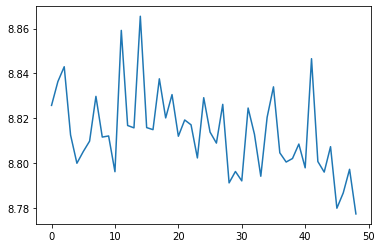

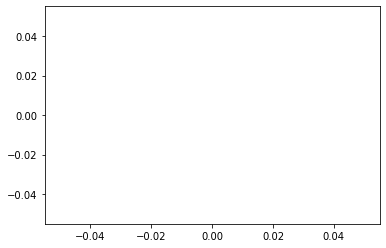

In [397]:
# mod1.plot_history()
# plt.show()
# mod1.plot_history(20000)
# plt.show()
# mod2.plot_history()
# plt.show()
# mod2.plot_history(20000)
# plt.show()
mod3.plot_history()
plt.show()
mod3.plot_history(20000)
plt.show()

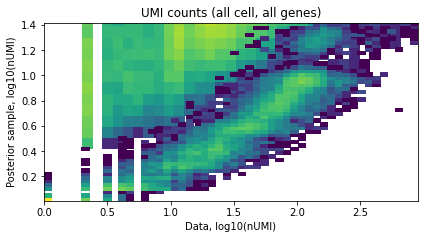

In [399]:
# mod1.sample_posterior(node='all', n_samples=1000, save_samples=False);
# mod1.sample2df()
# mod1.compute_expected()
# mod1.plot_posterior_mu_vs_data()
# plt.show()

# mod2.sample_posterior(node='all', n_samples=1000, save_samples=False);
# mod2.sample2df()
# mod2.compute_expected()
# mod2.plot_posterior_mu_vs_data()
# plt.show()

mod3.sample_posterior(node='all', n_samples=100, save_samples=False);
mod3.sample2df()
mod3.compute_expected()
mod3.plot_posterior_mu_vs_data()
mod3.plot_posterior_mu_vs_data(mu_node_name='mun', data_node='Y_data')
